# Error Analysis: Failure to Translate

In [1]:
%cd /exp/ssia/projects/icl_antilm_decoding

/exp/ssia/projects/icl_antilm_decoding


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

import json
import seaborn
sns.set_style('whitegrid')
from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import argparse
import os

rd = lambda x: np.around(x, 2)

In [3]:
from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import argparse
rd = lambda x: np.around(x, 2)

cfp = OmegaConf.load(f"configs/file_paths/logits.yaml")
model_cf = OmegaConf.load(f'configs/model/default.yaml')
data_cf = OmegaConf.load('configs/data/default.yaml')
format_cf = OmegaConf.load('configs/format/instr_L1L2.yaml')
generator_cf = OmegaConf.load('configs/generator/default.yaml')
logits_cf = OmegaConf.load('configs/logits_processor/default.yaml')
prompt_cf = OmegaConf.load('configs/prompt_select/random.yaml')

args = OmegaConf.merge(model_cf, data_cf, format_cf, generator_cf, logits_cf, prompt_cf)
args.seed = 0


#args = OmegaConf.merge(model_cf, data_cf, format_cf, generator_cf, training_cf, logits_cf, prompt_cf)

args.data.trainset = "FLORES"
args.data.testset = "FLORES"
args.data.doclevel = "sentence"
args.sample_prompts.nprompts = 0
args.seed = 0

In [4]:
results_cf = cfp['res_fn'].format(**args)

In [5]:
results_cf

'/exp/ssia/projects/icl_antilm_decoding/results/format-instr_L1L2/no_lengthfilter-random/gen-defaultsentence-DefaultLogits/FLORES-FLORES/gptn2.7B-nprompts0-seed0.en-fr.json'

In [58]:
# loop models
# loop anti_lm_x_0.3, pmi_x_0.1, greedy
MODELS = ['xglm2.9B', 'xglm7.5B', 'bloom3b', 'bloom7b1', 'llama7b', 'llama7b-chat']
MODES = ['anti_lm', 'pmi', 'default']
CONTRASTS = ['x']
ALPHAS = [0.1, 0.3]
scores = []

for mode in MODES:
    logits_cf = OmegaConf.load(f'configs/logits_processor/{mode}.yaml')
    args = OmegaConf.merge(args, logits_cf)
    for model in MODELS:
        for contrast in CONTRASTS:
            for alpha in ALPHAS:
                args.logitsp.contrast_logits_type = contrast
                if mode == "anti_lm" and alpha == 0.1:
                    continue
                if mode == "pmi" and alpha == 0.3:
                    continue
                args.logitsp.alpha = alpha
                args.model.model_size = model
                
                res_fn = cfp['gen_fn'].format(**args).replace('generated', 'results')
               # print(res_fn)
                if os.path.exists(res_fn):
                    #with open(res_fn, 'r') as f:
                    #    data = json.load(f)[0]
                    data = pd.read_csv(res_fn, sep=",")
                    score ={}
                    score['model'] = model
                    score['mode'] = mode
                    score['contrast'] = contrast
                    score['alpha'] = alpha
                   # score['bleu'] = data['sb']
                    score['lang'] = len(data[data['lang']=="en"])
                    scores.append(score)
                   # print(score)
scores = pd.DataFrame(scores)
scores.drop_duplicates(inplace=True)

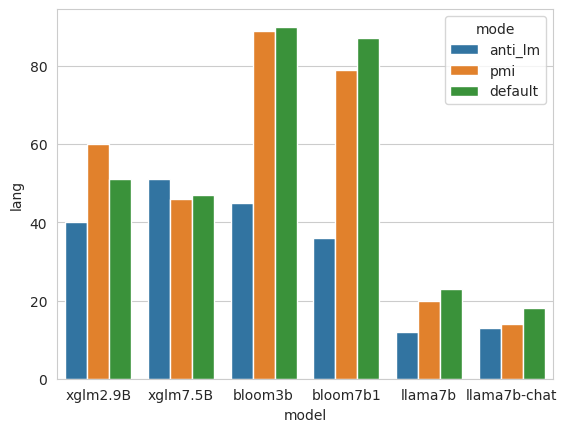

In [59]:
# something wrong wiht this graph
sns.barplot(scores, x="model", y="lang", hue="mode")
plt.show()

In [55]:
scores['model'].value_counts()

bloom3b     8
xglm2.9B    8
xglm7.5B    8
bloom7b1    8
Name: model, dtype: int64

In [14]:
cfp['gen_fn'].format(**args)

'/exp/ssia/projects/icl_antilm_decoding/generated/format-instr_L1L2/no_lengthfilter-random/gen-defaultsentence-AntiLM_x-0.3_decay/FLORES-FLORES/gptn2.7B-nprompts0-seed0.en-fr.csv.hyp'